In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch.nn.functional as F

import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torch import optim
from utils.dataset import NCDFDatasets
from utils.trainer import Trainer
from utils.trainer import Tester


Load specific variables for each dataset

In [4]:
version = 1
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset_type = 'chirps'
input_size = 50
step = 5
dropout_rate = 0.2
learning_rate = 0.001
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [5]:

#util = Util('STConvS2S', version=version, dataset_type=dataset_type)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [6]:
print(torch.version.cuda)

10.1


Seed

In [7]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [8]:
def init_seed(seed):
    np.random.seed(seed)

In [9]:
init_seed = init_seed(seed)

Hyperparameters

In [10]:
epochs = 50
batch_size = 25
validation_split = 0.2
test_split = 0.2
encoder_layer_size = param['encoder_layer_size']
decoder_layer_size = param['decoder_layer_size']
kernel_size = param['kernel_size']
filter_size = param['filter_size']

Loading the dataset

In [11]:
dataset = xr.open_dataset(data_path)
dataset

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...

In [12]:
data = NCDFDatasets(dataset, val_split = validation_split, test_split = test_split)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [13]:
print('[X_train] Shape:', train_data.x.shape)
print('[y_train] Shape:', train_data.y.shape)
print('[X_val] Shape:', val_data.x.shape)
print('[y_val] Shape:', val_data.y.shape)
print('[X_test] Shape:', test_data.x.shape)
print('[y_test] Shape:', test_data.y.shape)

[X_train] Shape: torch.Size([32429, 1, 5, 32, 32])
[y_train] Shape: torch.Size([32429, 1, 5, 32, 32])
[X_val] Shape: torch.Size([10809, 1, 5, 32, 32])
[y_val] Shape: torch.Size([10809, 1, 5, 32, 32])
[X_test] Shape: torch.Size([10809, 1, 5, 32, 32])
[y_test] Shape: torch.Size([10809, 1, 5, 32, 32])


In [14]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

Creating the model

In [15]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [16]:
class EncoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(EncoderSTCNN, self).__init__()
        self.padding = kernel_size // 2
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        
        spatial_kernel_size =  [1, kernel_size, kernel_size]
        spatial_padding =  [0, self.padding, self.padding]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=spatial_kernel_size, padding=spatial_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            in_channels = out_channels
        
    def forward(self, x):
        for conv, mish, batch in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers):
            x = conv(x)
            x = batch(x)
            x = mish(x)
            
        return x

In [17]:
class DecoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(DecoderSTCNN, self).__init__()
        self.padding = kernel_size - 1
        self.conv_layers = nn.ModuleList()
        self.mish_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()

        temporal_kernel_size =  [kernel_size, 1, 1]
        temporal_padding =  [self.padding, 0, 0]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=temporal_kernel_size, padding=temporal_padding, bias=False)
            )
            self.mish_layers.append(Mish())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            in_channels = out_channels

        padding_final = [kernel_size // 2, 0, 0]
        self.conv_final = nn.Conv3d(in_channels=in_channels, out_channels=1, 
              kernel_size=temporal_kernel_size, padding=padding_final, bias=True)
        
    def forward(self, x):
        for conv, mish, batch in zip(self.conv_layers, self.mish_layers, 
                                           self.batch_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = batch(x)
            x = mish(x)
            
        out = self.conv_final(x)
        return out

In [18]:
class STConvS2S(nn.Module):
    
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels):
        super(STConvS2S, self).__init__()
        
        self.encoder = EncoderSTCNN(layer_size=encoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=channels)
        self.decoder = DecoderSTCNN(layer_size=decoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=filter_size)
        
    def forward(self, x):
        out = self.encoder(x)
        return self.decoder(out)

In [19]:
model = STConvS2S(encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels=train_data.x.shape[1]).to(device)
criterion = torch.nn.L1Loss()
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)

Training the model

In [20]:
model_path = os.path.join('../../../models/CFSR/1_step/STConvS2S_Mish_Adamod_MAE' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, True, model_path, False, 5)


In [21]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 3.296506
Val Avg. Loss: 1.144453
=> Saving a new best
Train - Epoch 1, Epoch Loss: 1.146144
Val Avg. Loss: 1.071556
=> Saving a new best
Train - Epoch 2, Epoch Loss: 1.097391
Val Avg. Loss: 1.076468
Train - Epoch 3, Epoch Loss: 1.061190
Val Avg. Loss: 1.024217
=> Saving a new best
Train - Epoch 4, Epoch Loss: 1.034940
Val Avg. Loss: 1.004716
=> Saving a new best
Train - Epoch 5, Epoch Loss: 1.022893
Val Avg. Loss: 1.001530
=> Saving a new best
Train - Epoch 6, Epoch Loss: 1.013805
Val Avg. Loss: 1.015337
Train - Epoch 7, Epoch Loss: 1.008728
Val Avg. Loss: 1.016072
Train - Epoch 8, Epoch Loss: 0.997249
Val Avg. Loss: 0.995893
=> Saving a new best
Train - Epoch 9, Epoch Loss: 0.996238
Val Avg. Loss: 0.989449
=> Saving a new best
Train - Epoch 10, Epoch Loss: 0.991628
Val Avg. Loss: 1.065976
Train - Epoch 11, Epoch Loss: 0.987262
Val Avg. Loss: 0.969374
=> Saving a new best
Train - Epoch 12, Epoch Loss: 0.983850
Val Avg. Loss: 0.980503
Train - Epoch 13, Epoch

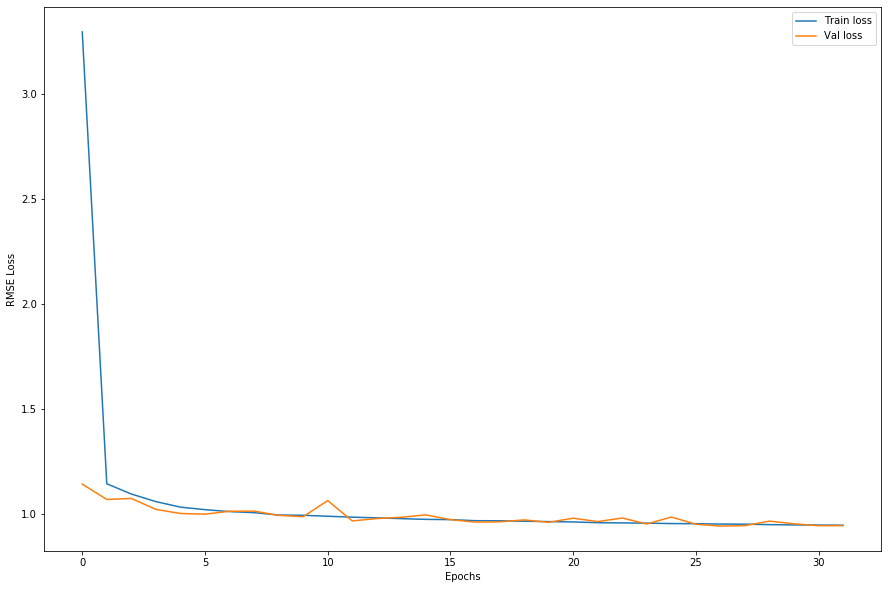

In [22]:
import matplotlib.pyplot as plt
epochs = np.arange(1,len(val_losses))
plt.figure(figsize=(15,10)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

Evaluating the model

In [23]:
model, optimizer, epoch, loss = trainer.load_model()
tester = Tester(model, test_loader, criterion, optimizer, device, True, False)
test_loss = tester.test()
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S L1Loss: 0.9327


In [44]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()